In [11]:
# Imports:
import numpy as np
import glob
import matplotlib.pyplot as plt
import pandas as pd
from scipy import *
import os
import matplotlib.cm as cm
import seaborn as sns
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
sns.set()
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, BatchNormalization, MaxPooling1D, Flatten
length = 277
import lime
import lime.lime_tabular

In [12]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5970856735860908932
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5803868160
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10835629155375993004
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 4070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9"
xla_global_id: 416903419
]


2024-02-15 17:18:19.124415: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-15 17:18:19.124574: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-15 17:18:19.124590: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-15 17:18:19.124888: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-15 17:18:19.124907: I tensorflow/core/common_runtime/gpu/gpu

train_values = pd.read_csv('./data/train_test/train_beats.csv').values
test_values = pd.read_csv('./data/train_test/test_beats.csv').values

print(train_values.shape)
print(test_values.shape)

X_train = train_values[:,:-2]
X_test = test_values[:,:-2]

X_train = X_train.reshape(-1, X_train.shape[1], 1)
X_test = X_test.reshape(-1, X_test.shape[1], 1)

y_train = train_values[:,-2]
y_test = test_values[:,-2]

y_train=to_categorical(y_train)
y_test=to_categorical(y_test)

In [14]:
from tensorflow.keras.layers import Dense, BatchNormalization, Flatten, Conv1D, MaxPooling1D

def getModel():
    
    cnnmodel = Sequential()
    cnnmodel.add(Conv1D(filters=128, kernel_size=16,padding='same', activation='relu',input_shape=(X_train.shape[1],X_train.shape[2])))
    cnnmodel.add(BatchNormalization())
    cnnmodel.add(Conv1D(filters=32, kernel_size=16,padding='same', activation='relu'))
    cnnmodel.add(BatchNormalization())
    cnnmodel.add(Conv1D(filters=9, kernel_size=16,padding='same', activation='relu',name = 'last_conv_layer'))
    cnnmodel.add(MaxPooling1D(pool_size=4,padding='same'))
    cnnmodel.add(Flatten())
    cnnmodel.add(Dense(256, activation='relu'))
    cnnmodel.add(Dense(128, activation='relu'))
    cnnmodel.add(Dense(32, activation='relu'))
    cnnmodel.add(Dense(7, activation='softmax'))
    cnnmodel.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
    return cnnmodel

cnnmodel = getModel()
cnnmodel.summary()

cnnhistory= cnnmodel.fit(X_train, y_train, epochs=10, verbose=1, validation_split=0.2, batch_size = 64)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 275, 128)          2176      
                                                                 
 batch_normalization_4 (Bat  (None, 275, 128)          512       
 chNormalization)                                                
                                                                 
 conv1d_5 (Conv1D)           (None, 275, 32)           65568     
                                                                 
 batch_normalization_5 (Bat  (None, 275, 32)           128       
 chNormalization)                                                
                                                                 
 last_conv_layer (Conv1D)    (None, 275, 9)            4617      
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 69, 9)            

In [15]:
pred = cnnmodel.predict(X_test)
accuracy_score(np.argmax(y_test, axis = 1), np.argmax(pred, axis = 1))

1171/1171 [==============================] - 2s 1ms/step


0.9426846856471343

In [31]:
class_nums = np.arange(1, 9)
counts = [np.count_nonzero(np.argmax(y_test, axis=1) == class_num) for class_num in class_nums]
counts


[28534, 1659, 2514, 1310, 754, 189, 401, 2081]

In [32]:
class_num = 6
N_test = test_values[test_values[:,-2]==class_num]

Xs_test = N_test[:,:-2]
ys_test = N_test[:len(N_test),-2]

Xs_test1 = Xs_test.reshape(-1, X_test.shape[1], 1)
ys_test1 = to_categorical(ys_test)

In [33]:
weights_class = []

for n in range (0, len(Xs_test1)):
    explainer = lime.lime_tabular.RecurrentTabularExplainer(X_train, feature_names = ['x'], discretize_continuous = True)
    exp = explainer.explain_instance(Xs_test1[n], cnnmodel.predict, labels = [class_num], num_features = 275)
    map_explanation = exp.as_map()[class_num]
    features, weights = [], []
    for e in map_explanation:
        features.append(e[0])
        weights.append(e[1])
    features = np.array(features)
    weights = np.array(weights)
    indices_sort = np.argsort(features)
    features = features[indices_sort]
    weights = weights[indices_sort]
    weights_class.append(weights)
weights_class = np.array(weights_class)


157/157 [==============================] - 0s 2ms/step


In [35]:
weights_class.shape


(189, 275)

In [36]:
weights_mean = np.mean(weights_class, axis=0)

In [37]:
# Average over the actual variables:
mean_weights = np.zeros((11, ))
for i in range(0, 275, 25):
    mean_weights[i // 25] = np.mean(weights_mean[i:i+25])

# Sort based on weight:
indices_sort = np.argsort(-1 * mean_weights)
slices = np.arange(1, 12)

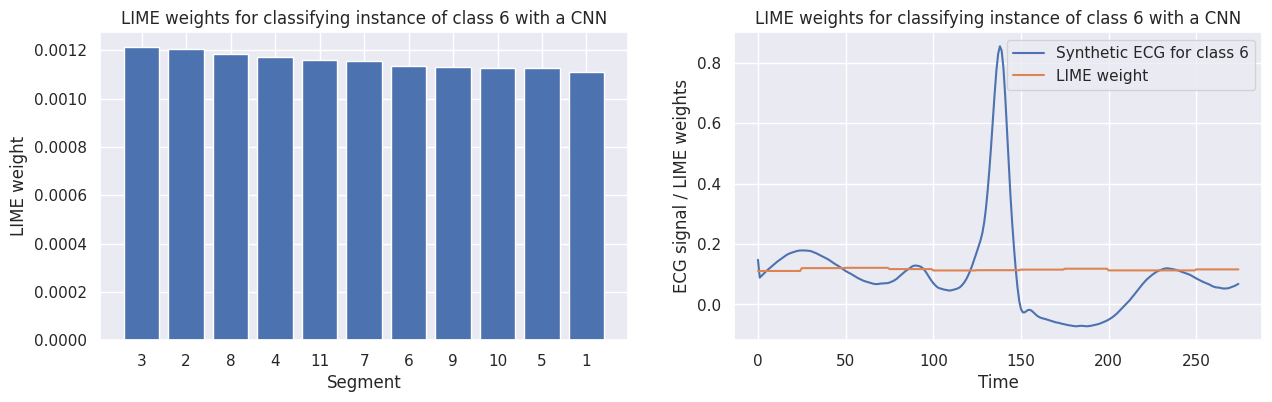

In [38]:
# Visualize:
fig, ax = plt.subplots(1, 2, figsize = (15, 4))
ax[0].bar(range(11), mean_weights[indices_sort])
ax[0].set_title('LIME weights for classifying instance of class ' + str(class_num) + ' with a CNN')
ax[0].set_xticks(np.arange(11))
ax[0].set_xticklabels(slices[indices_sort])
ax[0].set_ylabel('LIME weight')
ax[0].set_xlabel('Segment')

ecg_normalized_all = []

for n in range (0, len(Xs_test1)):
    ecg_normalized_temp = (Xs_test1[n, :, 0] - Xs_test1[n, :, 0].min()) / (Xs_test1[n, :, 0].max() - Xs_test1[n, :, 0].min())
    ecg_normalized_all.append(ecg_normalized_temp)
ecg_normalized_all = np.array(ecg_normalized_all)

ecg_class_mean = np.mean(ecg_normalized_all, axis=0)
ecg_normalized = (ecg_class_mean - ecg_class_mean.min()) / ecg_class_mean.max() - ecg_class_mean.min()

ax[1].plot(np.arange(275), ecg_normalized, label = 'Synthetic ECG for class ' + str(class_num))
ax[1].plot(np.repeat(mean_weights * 100, 25), label = 'LIME weight')
ax[1].set_title('LIME weights for classifying instance of class ' + str(class_num) + ' with a CNN')
ax[1].set_ylabel('ECG signal / LIME weights')
ax[1].set_xlabel('Time')
ax[1].legend()
plt.savefig('LIME weights for classifying instance of class ' + str(class_num) + ' with a CNN', dpi = 400)
